In [1]:
!wget https://machinehack-be.s3.amazonaws.com/computer_vision_classic_weekend_hackathon_11/Data.zip

--2020-07-10 14:25:33--  https://machinehack-be.s3.amazonaws.com/computer_vision_classic_weekend_hackathon_11/Data.zip
Resolving machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)... 52.219.64.32
Connecting to machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)|52.219.64.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 315463646 (301M) [application/octet-stream]
Saving to: ‘Data.zip’

Data.zip            100%[===================>] 300.85M  10.1MB/s    in 32s     

2020-07-10 14:26:06 (9.46 MB/s) - ‘Data.zip’ saved [315463646/315463646]



In [2]:
!unzip Data.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/Data/Train/Cats/._7194.jpg  
  inflating: Data/Train/Cats/15438.jpg  
  inflating: __MACOSX/Data/Train/Cats/._15438.jpg  
  inflating: Data/Train/Cats/9152.jpg  
  inflating: __MACOSX/Data/Train/Cats/._9152.jpg  
  inflating: Data/Train/Cats/6261.jpg  
  inflating: __MACOSX/Data/Train/Cats/._6261.jpg  
  inflating: Data/Train/Cats/11138.jpg  
  inflating: __MACOSX/Data/Train/Cats/._11138.jpg  
  inflating: Data/Train/Cats/12431.jpg  
  inflating: __MACOSX/Data/Train/Cats/._12431.jpg  
  inflating: Data/Train/Cats/6513.jpg  
  inflating: __MACOSX/Data/Train/Cats/._6513.jpg  
  inflating: Data/Train/Cats/12425.jpg  
  inflating: __MACOSX/Data/Train/Cats/._12425.jpg  
  inflating: Data/Train/Cats/18108.jpg  
  inflating: __MACOSX/Data/Train/Cats/._18108.jpg  
  inflating: Data/Train/Cats/8258.jpg  
  inflating: __MACOSX/Data/Train/Cats/._8258.jpg  
  inflating: Data/Train/Cats/11662.jpg  
  inflating: __MACOSX/Data/T

In [3]:
import pandas as pd

In [4]:
train=pd.read_csv('Data/Train.csv')

In [5]:
train.tail(2)

,File_Name,Category
9469,20605.jpg,1
9470,11785.jpg,0


In [6]:
df=train

In [7]:
x = df[df['Category']==1]
y = df[df['Category']==0]

In [8]:
x.head(10)

,File_Name,Category
0,10846.jpg,1
1,2360.jpg,1
3,13254.jpg,1
8,17804.jpg,1
9,3200.jpg,1
10,6603.jpg,1
14,12297.jpg,1
23,3108.jpg,1
25,16431.jpg,1
26,6805.jpg,1


In [9]:
import shutil
for i in x['File_Name']:
  shutil.move("/content/Data/Train/Dogs/"+str(i), "/content/Data/Train/")

In [10]:
import shutil
for i in y['File_Name']:
  shutil.move("/content/Data/Train/Cats/"+str(i), "/content/Data/Train/")

In [12]:
%rm -rf '/content/Data/Train/Dogs'

In [13]:
%rm -rf '/content/Data/Train/Cats'

In [14]:
path= '/content/Data'
k= '/content/Data/Train.csv'
p ='/content/Data/Sample_Submission.csv'

In [15]:
train=pd.read_csv(k)
test=pd.read_csv(p)

In [16]:
train.head(5),test.head(5)

(   File_Name  Category
 0  10846.jpg         1
 1   2360.jpg         1
 2  17531.jpg         0
 3  13254.jpg         1
 4  15554.jpg         0,    File_Name  Category
 0   8121.jpg         1
 1  15486.jpg         1
 2   8132.jpg         1
 3  16297.jpg         1
 4  20838.jpg         1)

In [17]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [18]:
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from fastai.callbacks.hooks import *

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
path= '/content/Data/Train'
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0,do_flip=False,xtra_tfms=[cutout()])
data = (ImageList.from_csv(path, csv_name = '../Train.csv')
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = '../Test')              
        .transform(tfms, size=400)
        .databunch(num_workers=0,bs=8))

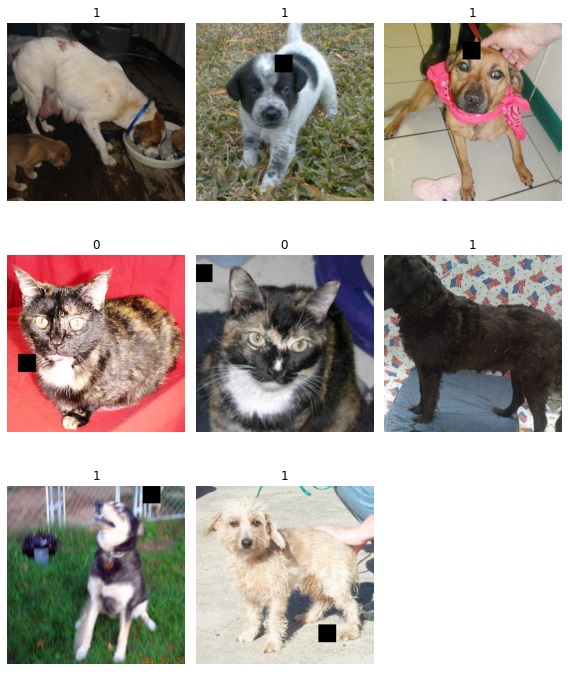

In [21]:
## to see the images in train with there labels
data.show_batch(rows=3, figsize=(8,10))

In [22]:
## print the target classes
print(data.classes)

[0, 1]


In [23]:
learn = cnn_learner(data, models.densenet169, metrics=[error_rate, accuracy], model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/checkpoints/densenet169-b2777c0a.pth


In [24]:

from fastai import *
from fastai.vision import *
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import shutil
from sklearn.metrics import f1_score, confusion_matrix

np.random.seed(1786)
ROOT = "/tmp/data0125004"

In [25]:

def read_data(root):
    train_df = pd.read_csv(k)
    test_df = pd.read_csv(p)
    return train_df, test_df

In [26]:
class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics):        
        loss, acc = metrics[0], metrics[1]
        if (self.best_acc is None) or (acc > self.best_acc) or (loss < self.best_loss):
            self.best_acc = acc
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Save the best acc {:.5f}".format(self.best_acc))
        elif acc == self.best_acc and  loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Acc is eq,Save the lower loss {:.5f}".format(self.best_loss))
            
    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)

In [27]:
#Path(ROOT).mkdir(exist_ok=True, parents=True)
src1 = "/content/Data"
shutil.copytree(src1, ROOT)


if __name__=="__main__":
    train_df, test_df = read_data(ROOT)
    print(train_df.shape, test_df.shape)
    
    cvlist = list(StratifiedKFold(16, random_state=12345786).split(train_df, train_df.Category))
    
    tfms1 = get_transforms(max_zoom=1.5)
    test_preds_all = []
    val_preds_all = []
    for i in range(1):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        src = (ImageList.from_df(train_df, path=ROOT, folder="Train").split_by_idxs(tr_idx, val_idx)
                                                            .label_from_df())
        data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms1, size=224, bs=32, resize_method=3).normalize(imagenet_stats)
        data.add_test(ImageList.from_df(test_df, path=ROOT, folder="Test"))
        learn = cnn_learner(data, models.densenet169, metrics=accuracy, ps=0.5)
        # learn.model[0].load_state_dict(torch.load("../input/save-body-weights-marvel/bestmodel_body.path"))
        cb = SaveBestModel(learn, name="bestmodel_{}".format(i))
        # learn.fit(1, callbacks=cb)
        learn.fit_one_cycle(4)
        learn.unfreeze()
        learn.fit_one_cycle(10, max_lr=1e-4, callbacks=[cb])
        #learn.fit_one_cycle(10, max_lr=5e-5, callbacks=[cb])
        #learn.fit_one_cycle(10, max_lr=1e-5, callbacks=[cb])
        #learn.fit_one_cycle(10, max_lr=5e-6, callbacks=[cb])
        learn.fit_one_cycle(2, max_lr=1e-6, callbacks=[cb])
        learn.load("bestmodel_{}".format(i))
        val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        src = str(Path(ROOT) / "models" / fname)
        shutil.copy(src, fname)
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)

    np.save("test_preds.npy", test_preds_all)
    np.save("val_preds.npy", val_preds_all)

(9471, 2) (4059, 2)
Starting fold 0
(8879,) (592,)


epoch,train_loss,valid_loss,accuracy,time
0,0.125383,0.053681,0.988176,02:26
1,0.066541,0.029117,0.988176,02:22
2,0.040452,0.017326,0.994932,02:21
3,0.019416,0.020425,0.993243,02:21


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.013607,0.015622,0.998311,02:52
1,0.038808,0.033374,0.989865,02:51
2,0.059749,0.025891,0.991554,02:51
3,0.036771,0.025633,0.993243,02:51
4,0.046967,0.051614,0.978041,02:51
5,0.025069,0.029013,0.989865,02:50
6,0.014131,0.027843,0.993243,02:49
7,0.011887,0.024710,0.994932,02:49
8,0.005488,0.017413,0.994932,02:49


Save the best acc 0.99831


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.004020,0.018789,0.994932,02:49
1,0.006055,0.018743,0.994932,02:48


F1 score for this fold  0.9983108059909321


In [30]:
sub=test_df[['File_Name']]
sub['Category']=np.argmax(test_preds,axis=1)
sub.to_csv('dense169.csv',index=False)

In [ ]:
from google.colab import files
files.download('dense169.csv')